In [1]:
#loading the Required Libraries
import pandas as pd
import json
import numpy as np
import pandas.io.json as pd_json
import seaborn as sn
import matplotlib.pyplot as plt
import flatten_json as fj
import collections
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier,plot_importance
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,cross_validate,GridSearchCV
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,f1_score,make_scorer,accuracy_score
from sklearn.feature_selection import SelectFromModel

Data is saved in local directory.While going through the data set it is in json format.So to apply the machine learning algorithm we need to have some structured  format. But even though i did'nt found any direct useful features.So, some feature engineering is done to extract the feature form data. Maybe features which i have created may not useful for modelling this information can be get by the feature importance Section

# Data Pre-Processing

In [2]:
#converting the data into proper json data
with open("C:/Users/MUKHESH/OneDrive/Documents/Data_Science_Test/customersdata.json","r") as f:
    json_data=[json.loads(i) for i in f.readlines()]

In [3]:
#Setting the columns which to be extracted from json data
column_names=['customer_email','no_order_pending',
              'no_order_fulfilled','no_order_failed','payment_bitcoin','payment_wallet','payment_card',
              'failed_payment_bitcoin','failed_payment_wallet','failed_payment_card',
              'payment_provider_JCB','payment_provider_visa','payment_provider_other',
              'amount_of_percentage_transaction_failed','no_of_transaction_order_repeated_more',
              'order_address_matching_percentage','no_transaction_failure_percentage',
              'no_of_payment_method','fraudulent']


In [4]:
#creating the function which extract the features from json data
def process_data(json_data):
    df_data=[]
    for i in range(len(json_data)):
        dict_data={'customer_email':json_data[i]['customer']['customerEmail'],'no_order_pending':0,
              'no_order_fulfilled':0,'no_order_failed':0,'payment_bitcoin':'No','payment_wallet':'No',
              'payment_card':'No','failed_payment_bitcoin':'No','failed_payment_wallet':'No',
              'failed_payment_card':'No','payment_provider_JCB':'No','payment_provider_visa':'No',
              'payment_provider_other':'No','amount_of_percentage_transaction_failed':0,
              'no_of_transaction_order_repeated_more':0,'order_address_matching_percentage':0,
              'no_transaction_failure_percentage':0,'no_of_payment_method':0,'fraudulent':json_data[i]['fraudulent']}
        no_of_orders=len(json_data[i]['orders'])
        
        counter=collections.Counter()
        
        for order in json_data[i]['orders']:
            counter.update(order)
        
        total_amount=counter['orderAmount']
        dict_data['no_of_payment_method']=len(json_data[i]['paymentMethods'])
        no_transaction=len(json_data[i]['transactions'])
        failed_order=dict()
        failed_payment=set()
        transaction_order=dict()
        transaction_failed_percentage=0
        for transaction in json_data[i]['transactions']:
            if transaction['transactionFailed']:
                failed_order[transaction['orderId']]=transaction['transactionAmount']
                failed_payment.add(transaction['paymentMethodId'])
                transaction_failed_percentage+=1
            transaction_order[transaction['orderId']]=transaction_order[transaction['orderId']]+1 if ((transaction['orderId'] in transaction_order.keys()) and(transaction_order[transaction['orderId']]>0)) else 0
        dict_data['no_transaction_failure_percentage']=(transaction_failed_percentage/no_transaction) if no_transaction>0 else 0
                
                
        for order in json_data[i]['orders']:
            dict_data['no_order_pending']=dict_data['no_order_pending']+1 if order['orderState']=='pending' else dict_data['no_order_pending']
            dict_data['no_order_fulfilled']=dict_data['no_order_fulfilled']+1 if order['orderState']=='fulfilled' else dict_data['no_order_fulfilled']
            dict_data['no_order_failed']=dict_data['no_order_failed']+1 if order['orderState']=='failed' else dict_data['no_order_failed']
            dict_data['order_address_matching_percentage']=dict_data['order_address_matching_percentage']+1 if order['orderShippingAddress']!=json_data[i]['customer']['customerBillingAddress'] else dict_data['order_address_matching_percentage']
            dict_data['no_of_transaction_order_repeated_more']=dict_data['no_of_transaction_order_repeated_more']+1 if transaction_order[order['orderId']]>0 else dict_data['no_of_transaction_order_repeated_more']
            dict_data['amount_of_percentage_transaction_failed']=dict_data['amount_of_percentage_transaction_failed']+failed_order[order['orderId']] if order['orderId'] in failed_order.keys() else dict_data['amount_of_percentage_transaction_failed']
            
        for column in ['no_order_pending','no_order_fulfilled','no_order_failed','order_address_matching_percentage','no_of_transaction_order_repeated_more']:
            if no_of_orders>0:
                dict_data[column]/=no_of_orders
        
        dict_data['amount_of_percentage_transaction_failed']=dict_data['amount_of_percentage_transaction_failed']/total_amount if total_amount>0 else dict_data['amount_of_percentage_transaction_failed'] 
        
        for payment in json_data[i]['paymentMethods']:
            dict_data['payment_bitcoin']='Yes' if payment['paymentMethodType']=='bitcoin' else dict_data['payment_bitcoin']
            dict_data['payment_card']='Yes' if payment['paymentMethodType']=='card' else dict_data['payment_card']
            dict_data['payment_wallet']='Yes' if ((payment['paymentMethodType'] != 'bitcoin') and (payment['paymentMethodType'] != 'card')) else dict_data['payment_wallet']
            dict_data['payment_provider_visa']='Yes' if 'VISA' in payment['paymentMethodProvider'] else dict_data['payment_provider_visa']
            dict_data['payment_provider_JCB']='Yes' if 'JCB' in payment['paymentMethodProvider'] else dict_data['payment_provider_JCB']
            dict_data['payment_provider_other']='Yes' if (('VISA' not in payment['paymentMethodProvider']) and ('JCB' not in payment['paymentMethodProvider'])) else dict_data['payment_provider_other']
            dict_data['failed_payment_bitcoin']='Yes' if ((payment['paymentMethodId'] in failed_payment) and (dict_data['payment_bitcoin']==1)) else  dict_data['failed_payment_bitcoin']
            dict_data['failed_payment_card']='Yes' if ((payment['paymentMethodId'] in failed_payment) and (dict_data['payment_card']==1)) else  dict_data['failed_payment_card']
            dict_data['failed_payment_wallet']='Yes' if ((payment['paymentMethodId'] in failed_payment) and (dict_data['payment_wallet']==1)) else  dict_data['failed_payment_wallet']
        df_data.append(dict_data)
    return df_data

# Data Analysis

In [5]:
#creating the data frame to do data analyis
#to read the json_data we have json_normalise function which will make json data as tabular data
data=pd_json.json_normalize(process_data(json_data))

In [6]:
#print the shape of data
print(data.shape)

(168, 19)


In [7]:
#let us check stats
#we already done feature scaling so that max and min value is less
print(data.describe())

       no_order_pending  no_order_fulfilled  no_order_failed  \
count        168.000000          168.000000       168.000000   
mean           0.054812            0.707929         0.076545   
std            0.154411            0.370470         0.143745   
min            0.000000            0.000000         0.000000   
25%            0.000000            0.500000         0.000000   
50%            0.000000            0.845238         0.000000   
75%            0.000000            1.000000         0.125000   
max            1.000000            1.000000         0.500000   

       amount_of_percentage_transaction_failed  \
count                               168.000000   
mean                                  0.236309   
std                                   0.307136   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.113321   
75%                                   0.386656   
max                    

In [8]:
#no.of missing values
print(data.isnull().sum())

customer_email                             0
no_order_pending                           0
no_order_fulfilled                         0
no_order_failed                            0
payment_bitcoin                            0
payment_wallet                             0
payment_card                               0
failed_payment_bitcoin                     0
failed_payment_wallet                      0
failed_payment_card                        0
payment_provider_JCB                       0
payment_provider_visa                      0
payment_provider_other                     0
amount_of_percentage_transaction_failed    0
no_of_transaction_order_repeated_more      0
order_address_matching_percentage          0
no_transaction_failure_percentage          0
no_of_payment_method                       0
fraudulent                                 0
dtype: int64


In [9]:
#print the type of variables
print(data.dtypes)

customer_email                              object
no_order_pending                           float64
no_order_fulfilled                         float64
no_order_failed                            float64
payment_bitcoin                             object
payment_wallet                              object
payment_card                                object
failed_payment_bitcoin                      object
failed_payment_wallet                       object
failed_payment_card                         object
payment_provider_JCB                        object
payment_provider_visa                       object
payment_provider_other                      object
amount_of_percentage_transaction_failed    float64
no_of_transaction_order_repeated_more      float64
order_address_matching_percentage          float64
no_transaction_failure_percentage          float64
no_of_payment_method                         int64
fraudulent                                    bool
dtype: object


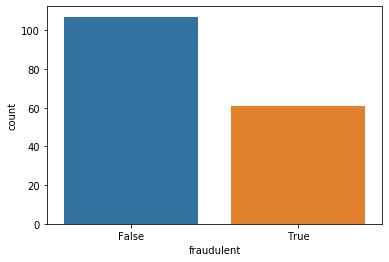

In [10]:
#let us check the distribution of target variable
sn.countplot(data['fraudulent'])
#As we can that negetive class occupies 63% of dataset

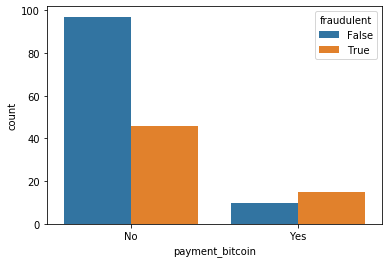

In [11]:
#categorical variables with respect to target class
sn.countplot(data['payment_bitcoin'],hue=data['fraudulent'])
#as we can see that fraudulent customer use bitcoin method more compared to non-fraudulent customers

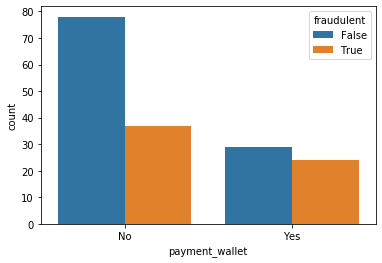

In [12]:
#categorical variables with respect to target class
sn.countplot(data['payment_wallet'],hue=data['fraudulent'])

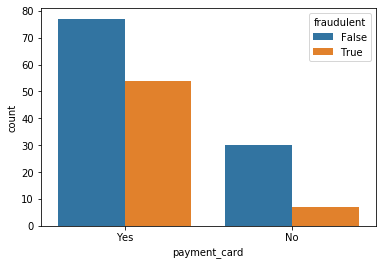

In [13]:
#categorical variables with respect to target class
sn.countplot(data['payment_card'],hue=data['fraudulent'])
#as we can see in  total fraudulent customer the card users are more

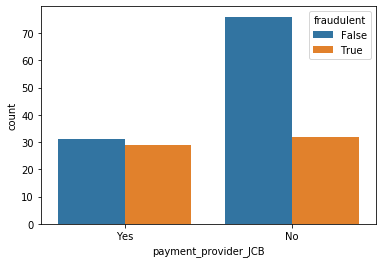

In [14]:
#categorical variables with respect to target class
sn.countplot(data['payment_provider_JCB'],hue=data['fraudulent'])

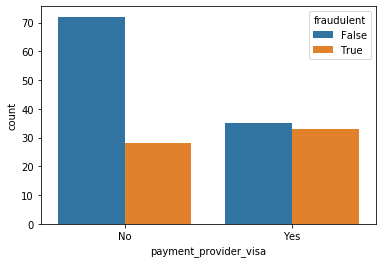

In [15]:
#categorical variables with respect to target class
sn.countplot(data['payment_provider_visa'],hue=data['fraudulent'])
#while using visa there is a good chance that customer might be a fraudulent

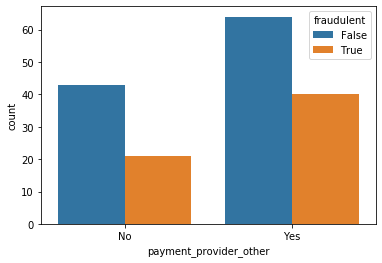

In [16]:
#categorical variables with respect to target class
sn.countplot(data['payment_provider_other'],hue=data['fraudulent'])

C:\Users\MUKHESH\AppData\Roaming\Python\Python36\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\MUKHESH\AppData\Roaming\Python\Python36\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


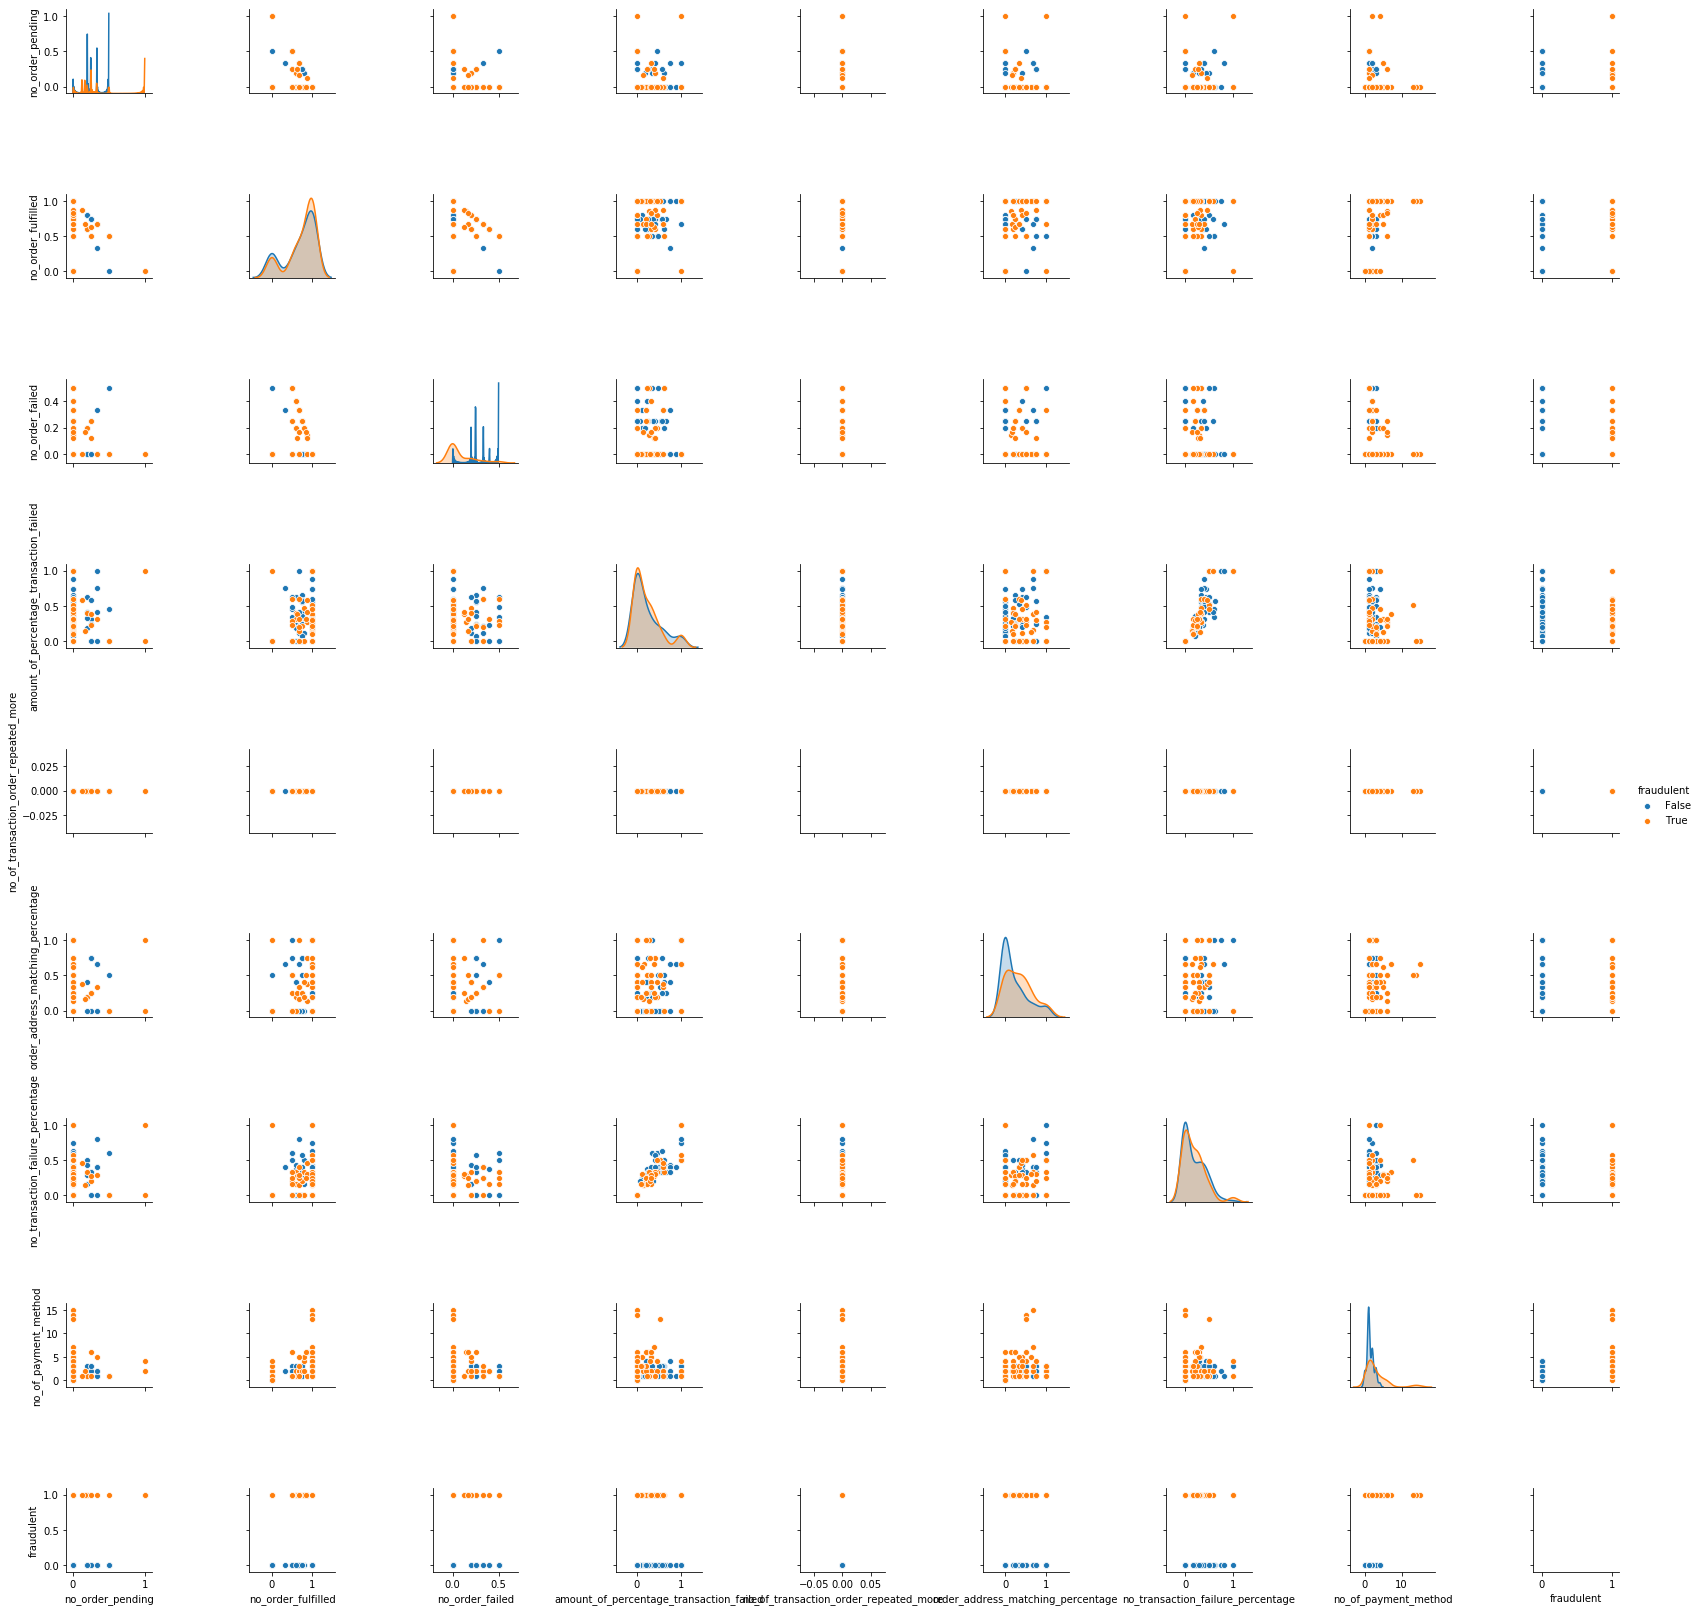

In [17]:
#constructing the pair plot to get the overview how data is distributed
sn.pairplot(data.iloc[:,[1,2,3,13,14,15,16,17,18]],hue='fraudulent')
#from seeing the data it is better to use the Knn,ensemble techniques because data is ovelaaped so logistic regression might not work well.

In [18]:
#changing to proper data type
for i in range(len(column_names)):
    if (data.iloc[:,i].dtypes=='object' or data.iloc[:,i].dtypes=='bool' ):
        data.iloc[:,i]=pd.Categorical(data.iloc[:,i])
        data.iloc[:,i]=data.iloc[:,i].cat.codes

# Modelling


In [19]:
#creating the stratified samples for cross validation
kfold=StratifiedKFold(n_splits=5,shuffle=True)

In [20]:
#Let us create a function for getting the cross validation scores to compare models
def cross_validation_scores(X_train,Y_train,kfold,classifiers):
    cross_val_scores={}
    scoring=['roc_auc','f1_weighted']
    for key in classifiers.keys():
        scores=cross_validate(classifiers[key],X_train,Y_train,scoring=scoring,n_jobs=-1,cv=kfold)
        cross_val_scores[key]={'test_auc':scores['test_roc_auc'].mean(),'test_f1_score':scores['test_f1_weighted'].mean(),'fit_time':scores['fit_time'].mean()}
    return cross_val_scores

In [21]:
#creating the instances of classifiers to fit on train data

#creating random forest
RF=RandomForestClassifier(n_jobs=-1)
#creating support vector classifier
svc=SVC()
#creating the xgboost classifier where scale_pos_weight to set the imbalnce ratio according to data set
xgb=XGBClassifier(scale_pos_weight=1.75,n_jobs=-1)
#creating the KNN classifier
knn=KNeighborsClassifier(n_jobs=-1)

In [28]:
#creating the list of classifiers
classifiers={'RandomForest':RandomForestClassifier(n_jobs=-1),'SVM':SVC(),'Xgboost':XGBClassifier(scale_pos_weight=1.75,n_jobs=-1),'KNN':KNeighborsClassifier(n_jobs=-1)}

In [29]:
#ignoring the first which does'nt add any information for model training
df=data.iloc[:,1:18]
#cretaing the target variable 
target=data.iloc[:,18].to_frame()
#spliting the data into test and train for model training
#stratify will make uniform distribution spliting based on target class
X_train,X_test,Y_train,Y_test=train_test_split(df,target,random_state=0,test_size=0.2,stratify=target)

In [32]:
#calling the cross validation function to compare the models
#here we choosing two scores auc and f1-score where auc score
#where f1-score will not concentrate on true negative which is essential in this scenario
cross_val_scores=cross_validation_scores(X_train,Y_train,kfold,classifiers) 
#printing
print(cross_val_scores)

{'RandomForest': {'test_auc': 0.5771895424836602, 'test_f1_score': 0.5474342591005288, 'fit_time': 0.15132575035095214}, 'SVM': {'test_auc': 0.6625490196078431, 'test_f1_score': 0.6348871122854863, 'fit_time': 0.010394048690795899}, 'Xgboost': {'test_auc': 0.6471895424836601, 'test_f1_score': 0.6111378348091273, 'fit_time': 0.16370630264282227}, 'KNN': {'test_auc': 0.6255555555555555, 'test_f1_score': 0.5953099093888568, 'fit_time': 0.008394384384155273}}


In [35]:
#when we observe scores xgboost is performing even though it is taking the fit time more
#fitting the train data
xgb.fit(X_train,Y_train)
#predicting the values
predicted_values=xgb.predict(X_test) 
#and printing the classification report
print(classification_report(Y_test,predicted_values))

              precision    recall  f1-score   support

           0       0.75      0.82      0.78        22
           1       0.60      0.50      0.55        12

    accuracy                           0.71        34
   macro avg       0.68      0.66      0.66        34
weighted avg       0.70      0.71      0.70        34



C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [36]:
#printing the feature importances
print(xgb.feature_importances_)


[0.02961832 0.06855159 0.05292837 0.08726466 0.03823032 0.04941926
 0.         0.         0.         0.05534024 0.1452639  0.07203347
 0.06109212 0.         0.07859363 0.09920036 0.1624638 ]


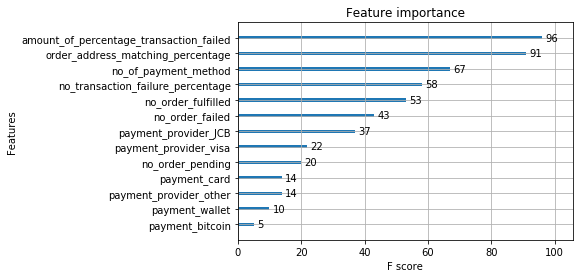

In [37]:
#we can see the importance of the feature the graph
plot_importance(xgb)
#as we can see that few columns importance is very small this might be it need few more data points

In [39]:
#storing the feature importances in varibale
feature_importance=xgb.feature_importances_
#Let us take a threshold to take the subset of feature
threshold=np.sort(feature_importance)

for thresh in threshold:
    selection=SelectFromModel(xgb,threshold=thresh,prefit=True)
    select_X_train=selection.transform(X_train)
    select_xgb=XGBClassifier(scale_pos_weight=1.75,n_jobs=-1)
    select_xgb.fit(select_X_train,Y_train)
    select_X_test=selection.transform(X_test)
    select_predicted_values=select_xgb.predict(select_X_test)
    print("Threshold:{}  no.of.features:{}  accuracy_score:{}".format(thresh,select_X_train.shape[1],accuracy_score(Y_test,predicted_values)))


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.0  no.of.features:17  accuracy_score:0.7058823529411765
Threshold:0.0  no.of.features:17  accuracy_score:0.7058823529411765
Threshold:0.0  no.of.features:17  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.0  no.of.features:17  accuracy_score:0.7058823529411765
Threshold:0.02961832471191883  no.of.features:13  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.03823032230138779  no.of.features:12  accuracy_score:0.7058823529411765
Threshold:0.04941926151514053  no.of.features:11  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.052928365767002106  no.of.features:10  accuracy_score:0.7058823529411765
Threshold:0.0553402379155159  no.of.features:9  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.06109212338924408  no.of.features:8  accuracy_score:0.7058823529411765
Threshold:0.06855159252882004  no.of.features:7  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.07203347235918045  no.of.features:6  accuracy_score:0.7058823529411765
Threshold:0.07859362661838531  no.of.features:5  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.08726466447114944  no.of.features:4  accuracy_score:0.7058823529411765
Threshold:0.09920036047697067  no.of.features:3  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of 

Threshold:0.1452638953924179  no.of.features:2  accuracy_score:0.7058823529411765
Threshold:0.16246379911899567  no.of.features:1  accuracy_score:0.7058823529411765


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [40]:
#where we can see that by reducing the features there is no much decrease in accuracy but feature deletion effect f1 score
#let us do hyperpameter tuning
params={
 'max_depth':range(3,10,2),#where max_depth restrict the depth of decision tree
 'min_child_weight':range(4,10,2),#where min_child_weight is similar no of observation for each leaf in GBM but here sum of weights of observation for each leaf.
 'gamma':[i/10.0 for i in range(0,5)]#where gamma decides the node spiltting based on postive value reduction in loss_function.      
 }
#grid search is used because data points is less
grid_search=GridSearchCV(estimator=XGBClassifier(scale_pos_weight=1.75,n_jobs=-1),param_grid=params,cv=kfold,n_jobs=-1,scoring='roc_auc')
grid_search.fit(X_train,Y_train)
#printing the best parameters,best estimator amoung these various parameter
print(grid_search.best_score_,grid_search.best_estimator_,grid_search.best_params_)

0.6624670763827918 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.75, seed=None,
              silent=None, subsample=1, verbosity=1) {'gamma': 0.4, 'max_depth': 5, 'min_child_weight': 4}


C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
#copying the best parameter to variable
best_model=grid_search.best_estimator_
#fitting the model
best_model.fit(X_train,Y_train)

C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\MUKHESH\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.4,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1.75, seed=None,
              silent=None, subsample=1, verbosity=1)

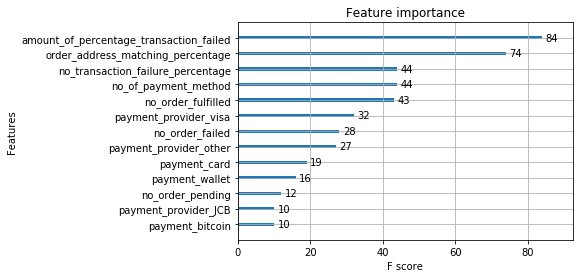

In [45]:
#plotting the importances after hyperparameter tuning
plot_importance(best_model)
#as we observe below the feature score is increased for few of the columns

In [46]:
#predicting the class
predicted_values=best_model.predict(X_test)
#printing classification report 
print(classification_report(Y_test,predicted_values))
#there is increase in f1-score

              precision    recall  f1-score   support

           0       0.76      0.73      0.74        22
           1       0.54      0.58      0.56        12

    accuracy                           0.68        34
   macro avg       0.65      0.66      0.65        34
weighted avg       0.68      0.68      0.68        34



There might be less accuracy due to less important features or i think data should add some few important features like timings of transactions,country,gender etc... then we would be getting the good accurate model.